In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from opxrd.wrapper import OpXRD
from opxrd.analysis import PlotAnalysis

t1 = '/media/daniel/mirrors/xrd.aimat.science/local/final/CNRS'
t2 = '/media/daniel/mirrors/xrd.aimat.science/local/final/HKUST'
full_dirpath = '/home/daniel/OneDrive/Downloads/opxrd_in_situ/LBNL'

d1 = OpXRD.load(dirpath=t1)
d2 = OpXRD.load(dirpath=t2)
analyser = PlotAnalysis(databases=[d1, d2], output_dirpath='/tmp/opxrd_analysis')

  5% (54 of 1058) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:03

Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS


100% (1058 of 1058) |####################| Elapsed Time: 0:00:04 Time:  0:00:040000
 11% (60 of 520) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
Successfully extracted 1058 patterns from 1058/1058 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST


100% (520 of 520) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST
Successfully extracted 520 patterns from 520/520 xrd files


---> Combined pattern plot for databaes ['a:CNRS', 'b:HKUST'] | No. patterns = 50

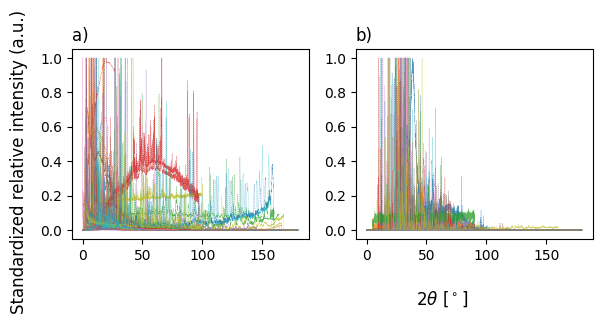

In [13]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for CNRS | No. patterns = 1058
[Debug]: Performing PCA for HKUST | No. patterns = 520


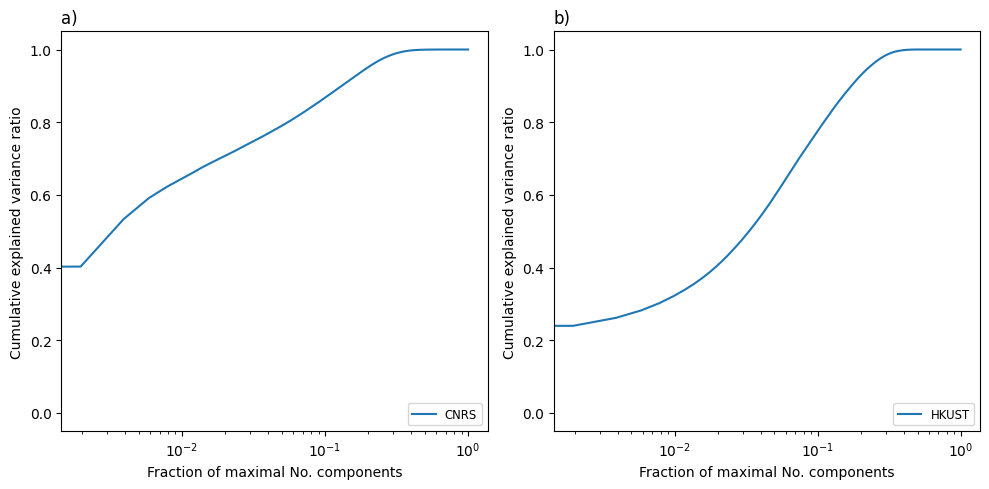

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for CNRS | No. patterns = 1058
[Debug]: Performing PCA for HKUST | No. patterns = 520


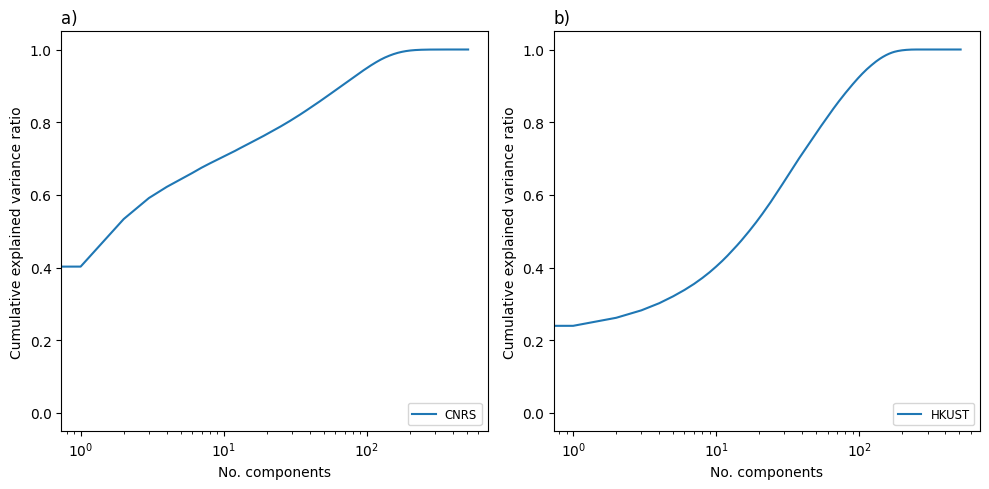

In [14]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

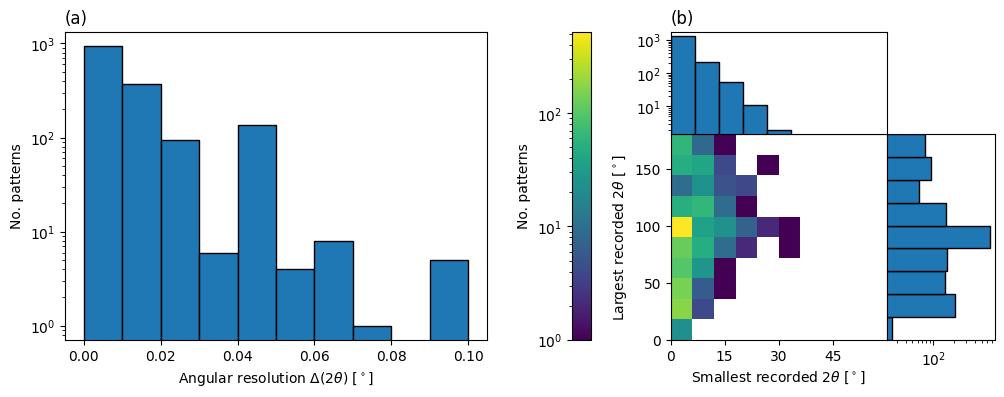

---> Histograms detailing properties of all patterns in the opXRD database: a) distribution of angular resolu-tion in all data; b) distribution of smallest and largest recorded 2θ values for all data.

In [15]:
analyser.xrd_histogram()
analyser.print_text(f'---> Histograms detailing properties of all patterns in the opXRD database: a) distribution of angular resolu-tion in all data; b) distribution of smallest and largest recorded 2θ values for all data.')

ValueError: Pattern Ba4 Sr4 Mo4 O16 has no primary phase

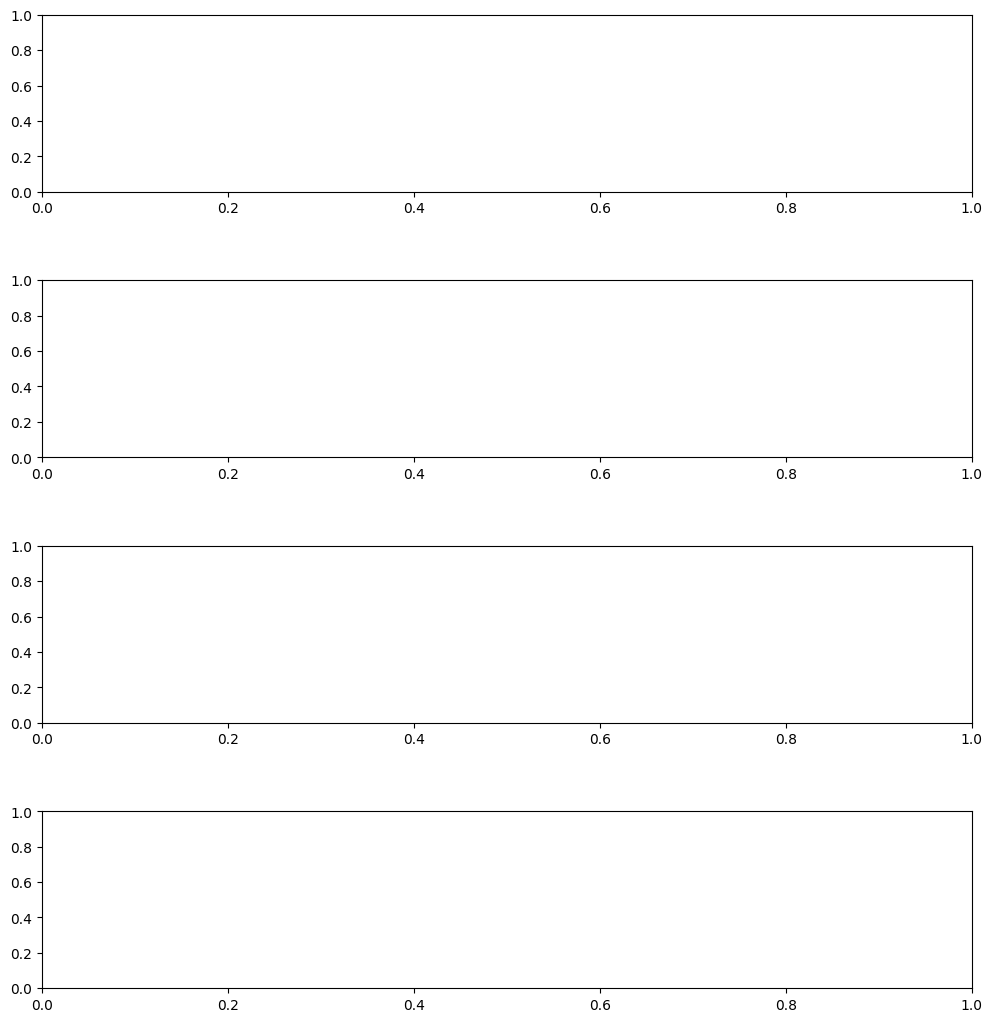

In [16]:
analyser.structure_histogram()
analyser.print_text(f'---> Histograms detailing properties of labeled patterns in the opXRD database: '
                    f'a) distribution of elements occuring in samples;'
                    r'b) distribution of spacegroups; c) distribution of No. atoms N_{\text{atom}}; '
                    r'd) distribution of unit cell volume V_{\text{uc}}')

In [18]:
analyser.show_label_fractions()

---> Overview of label fractions per contribution

+-------------+----------------+-----------+----------+---------------+---------------+
|             |   No. patterns |   lattice |      spg |   atom_coords |   composition |
|-------------+----------------+-----------+----------+---------------+---------------|
| CNRS        |           1058 | 1         | 1        |     0.842155  |      0.842155 |
| HKUST       |            520 | 0.0403846 | 0        |     0.0403846 |      0        |
| Σ Labeled   |           1079 | 1         | 0.980538 |     0.845227  |      0.825765 |
| Σ Unlabeled |            499 | 0         | 0        |     0         |      0        |
+-------------+----------------+-----------+----------+---------------+---------------+
